In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808330 sha256=5ba89558f1b3da789217f10ddc957434510cf312289bc269d144bf38bf0ce30e
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [3]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, reciprocal_rank
from lightfm.cross_validation import random_train_test_split
import matplotlib.pyplot as plt
import joblib

In [4]:
# Load your data
users_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/products.csv')
events_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/events.csv')


In [5]:
# Preprocessing
event_type_weights = {
    'purchase': 3.0,   # High weight as it directly indicates a preference.
    'cart': 2.5,       # Adding to cart is a strong buying signal.
    'product': 2.0,    # Viewing a product shows interest.
    'department': 1.0, # Browsing a department shows mild interest.
    'cancel': 0.5,     # Cancelling might indicate disinterest.
    'home': 0.5        # Visiting the home page is generic, low informational value.
}

events_df['event_weight'] = events_df['event_type'].map(event_type_weights)

events_df['product_id'] = events_df.apply(lambda row: int(row['uri'].split('/')[-1]) if '/product/' in row['uri'] else np.nan, axis=1)

events_df = events_df.dropna(subset=['product_id', 'user_id'])

events_df.loc[:, 'user_id'] = events_df['user_id'].astype(int)
events_df.loc[:, 'product_id'] = events_df['product_id'].astype(int)

filtered_events = events_df[events_df['user_id'].isin(users_df['id']) & events_df['product_id'].isin(products_df['id'])]

# Add age group feature to users
users_df['age_group'] = pd.cut(users_df['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])


print(filtered_events.head())
print(users_df.head())


    id  user_id  sequence_number                            session_id  \
2    3        1                3  2f64d862-461c-4aae-b6dc-01e0d196f798   
6    7        1                2  8a2213d3-4d80-4623-9310-5985e13cb40f   
9   10        1                5  8a2213d3-4d80-4623-9310-5985e13cb40f   
13  14        1                2  f3f101ae-94fa-4b90-af09-1ac93b882863   
16  17        1                5  f3f101ae-94fa-4b90-af09-1ac93b882863   

                 created_at      ip_address   city                state  \
2   2023-04-29 06:18:09 UTC   134.4.186.186  Wesel  Nordrhein-Westfalen   
6   2021-08-09 06:23:40 UTC  139.232.60.144  Wesel  Nordrhein-Westfalen   
9   2021-08-09 06:29:08 UTC  139.232.60.144  Wesel  Nordrhein-Westfalen   
13  2021-08-09 07:35:19 UTC    71.0.229.176  Wesel  Nordrhein-Westfalen   
16  2021-08-09 07:39:56 UTC    71.0.229.176  Wesel  Nordrhein-Westfalen   

   postal_code  browser traffic_source             uri event_type  \
2        46487   Chrome       Faceb

In [6]:
from lightfm.data import Dataset

# Initialize the dataset
dataset = Dataset()

# Fit the dataset with the user IDs, item IDs, and declare the features to use
dataset.fit(
    users=(x for x in users_df['id']),
    items=(x for x in products_df['id']),
    user_features=(f"{row['gender']}_{row['age_group']}_{row['state']}" for index, row in users_df.iterrows()),
    item_features=(f"{row['category']}_{row['brand']}_{row['department']}" for index, row in products_df.iterrows())
)

(interactions_matrix, weights_matrix) = dataset.build_interactions(
    (row['user_id'], row['product_id'], row['event_weight'])
    for index, row in events_df.iterrows()
)

user_features = dataset.build_user_features(
    (row['id'], [f"{row['gender']}_{row['age_group']}_{row['state']}"])
    for index, row in users_df[users_df['id'].isin(filtered_events['user_id'])].iterrows()
)

item_features = dataset.build_item_features(
    (row['id'], [f"{row['category']}_{row['brand']}_{row['department']}"])
    for index, row in products_df.iterrows()
)


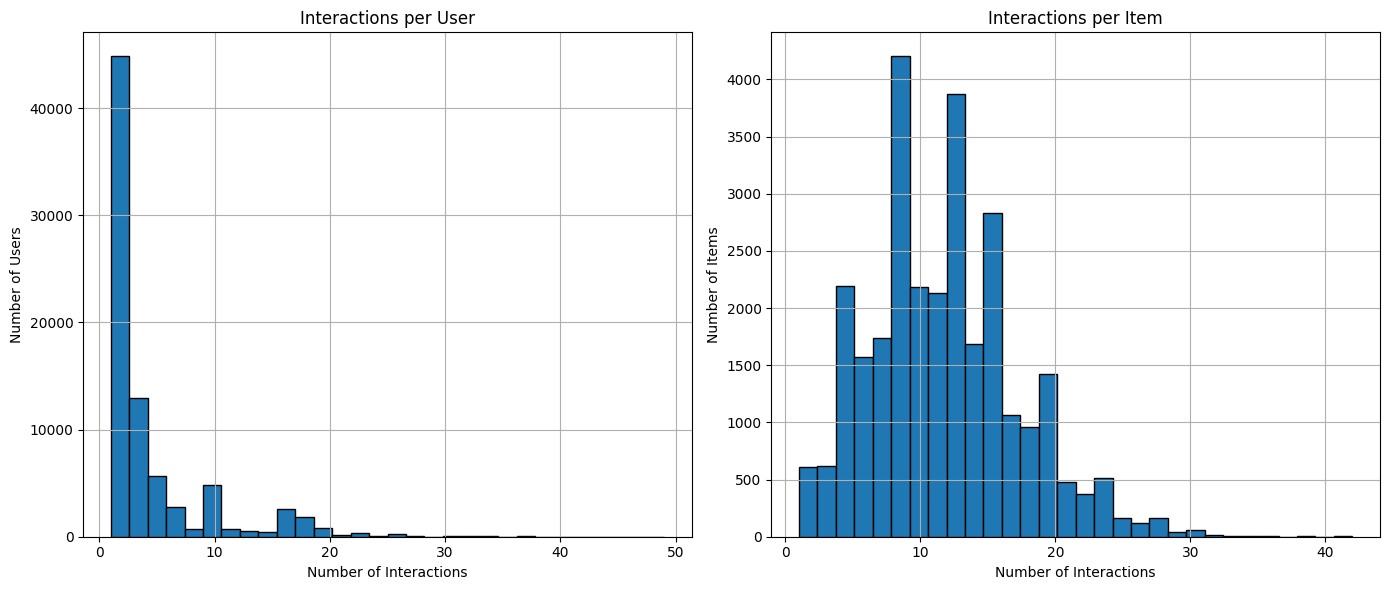

In [7]:
import matplotlib.pyplot as plt

# Assuming 'filtered_events' is your final events DataFrame after preprocessing
# Interactions per User
user_interactions = filtered_events.groupby('user_id').size()
item_interactions = filtered_events.groupby('product_id').size()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
user_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
item_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')

plt.tight_layout()
plt.show()


In [8]:
# Split the data into training and testing sets
train, test = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=np.random.RandomState(779))

# Initialize the LightFM model with WARP loss function
# Adjust these parameters to optimize the gap stability
learning_rate = 0.03  # Lower learning rate
no_components = 30    # Fewer factors to reduce complexity
user_alpha = 1e-4     # Higher regularization
item_alpha = 1e-4     # Higher regularization


# Initialize the model with adjusted parameters for better performance and regularization
model = LightFM(loss='warp', no_components=no_components,
                user_alpha=user_alpha, item_alpha=item_alpha,
                learning_schedule='adagrad', learning_rate=learning_rate, random_state=1616)

In [9]:
# Initialize lists to store the metrics
train_auc_list, test_auc_list, gap_list = [], [], []
train_rr_list, test_rr_list = [], []

num_epochs = 50
evaluation_interval = 5
best_gap = 0.05
patience = 3
patience_counter = 0
num_thread = 4

for epoch in range(num_epochs):
    model.fit_partial(train, user_features=user_features, item_features=item_features, epochs=1,
                      num_threads=num_thread)

    if (epoch + 1) % evaluation_interval == 0:
        train_rr = reciprocal_rank(model, train, user_features=user_features, item_features=item_features).mean()
        test_rr = reciprocal_rank(model, test, user_features=user_features, item_features=item_features).mean()
        train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
        test_auc = auc_score(model, test, user_features=user_features, item_features=item_features).mean()

        current_gap = train_auc - test_auc
        train_rr_list.append(train_rr)
        test_rr_list.append(test_rr)
        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)
        gap_list.append(current_gap)

        print(f'Epoch: {epoch+1} - Train RR: {train_rr:.4f}, Test RR: {test_rr:.4f}')
        print(f'Epoch: {epoch+1} - Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}, Gap: {current_gap:.4f}')

        # Monitor the gap and apply early stopping if it exceeds the threshold
        if current_gap < best_gap:
            patience_counter = 0
            joblib.dump(model, '/content/best_recommendation_hybrid_model.pkl')  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience or current_gap > 0.05:
                print(f"Early stopping triggered due to gap exceeding {best_gap} or no improvement")
                joblib.dump(model, '/content/recommendation_hybrid_model.pkl')
                break

Epoch: 5 - Train RR: 0.0029, Test RR: 0.0019
Epoch: 5 - Train AUC: 0.7922, Test AUC: 0.7780, Gap: 0.0142
Epoch: 10 - Train RR: 0.0036, Test RR: 0.0023
Epoch: 10 - Train AUC: 0.8043, Test AUC: 0.7858, Gap: 0.0185
Epoch: 15 - Train RR: 0.0044, Test RR: 0.0026
Epoch: 15 - Train AUC: 0.8139, Test AUC: 0.7912, Gap: 0.0227
Epoch: 20 - Train RR: 0.0053, Test RR: 0.0031
Epoch: 20 - Train AUC: 0.8233, Test AUC: 0.7966, Gap: 0.0267
Epoch: 25 - Train RR: 0.0067, Test RR: 0.0038
Epoch: 25 - Train AUC: 0.8328, Test AUC: 0.8018, Gap: 0.0310
Epoch: 30 - Train RR: 0.0083, Test RR: 0.0045
Epoch: 30 - Train AUC: 0.8430, Test AUC: 0.8072, Gap: 0.0359
Epoch: 35 - Train RR: 0.0105, Test RR: 0.0053
Epoch: 35 - Train AUC: 0.8532, Test AUC: 0.8126, Gap: 0.0406
Epoch: 40 - Train RR: 0.0133, Test RR: 0.0067
Epoch: 40 - Train AUC: 0.8635, Test AUC: 0.8181, Gap: 0.0454
Epoch: 45 - Train RR: 0.0164, Test RR: 0.0078
Epoch: 45 - Train AUC: 0.8737, Test AUC: 0.8234, Gap: 0.0503
Early stopping triggered due to gap exc

In [10]:
# Final evaluation at the end of training
train_precision = precision_at_k(model, train, k=10, user_features=user_features, item_features=item_features).mean()
test_precision = precision_at_k(model, test, k=10, user_features=user_features, item_features=item_features).mean()
train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
test_auc = auc_score(model, test, user_features=user_features, item_features=item_features).mean()

print('Final evaluation results:')
print(f'Precision: Train {train_precision:.4f}, Test {test_precision:.4f}')
print(f'AUC: Train {train_auc:.4f}, Test {test_auc:.4f}')


Final evaluation results:
Precision: Train 0.0037, Test 0.0016
AUC: Train 0.8737, Test 0.8234


In [11]:
# Sample recommendation function
def sample_recommendation(model, user_id, user_features, item_features, dataset, num_items=10):
    n_users, n_items = dataset.interactions_shape()
    user_x = dataset.mapping()[0][user_id]
    scores = model.predict(user_x, np.arange(n_items), user_features=user_features, item_features=item_features)
    top_items = np.argsort(-scores)[:num_items]

    return [dataset.mapping()[2][i] for i in top_items]

# Test the recommendation function for a specific user 17033
user_id = 1
recommended_products = sample_recommendation(model, user_id, user_features, item_features, dataset)
print(f'Recommended product IDs for user {user_id}: {recommended_products}')

Recommended product IDs for user 1: [3394, 28257, 25252, 7158, 25899, 20814, 13720, 17643, 10603, 21211]


In [12]:
joblib.dump(model, 'recommend_model.pkl')

['recommendation_hybrid_model.pkl']

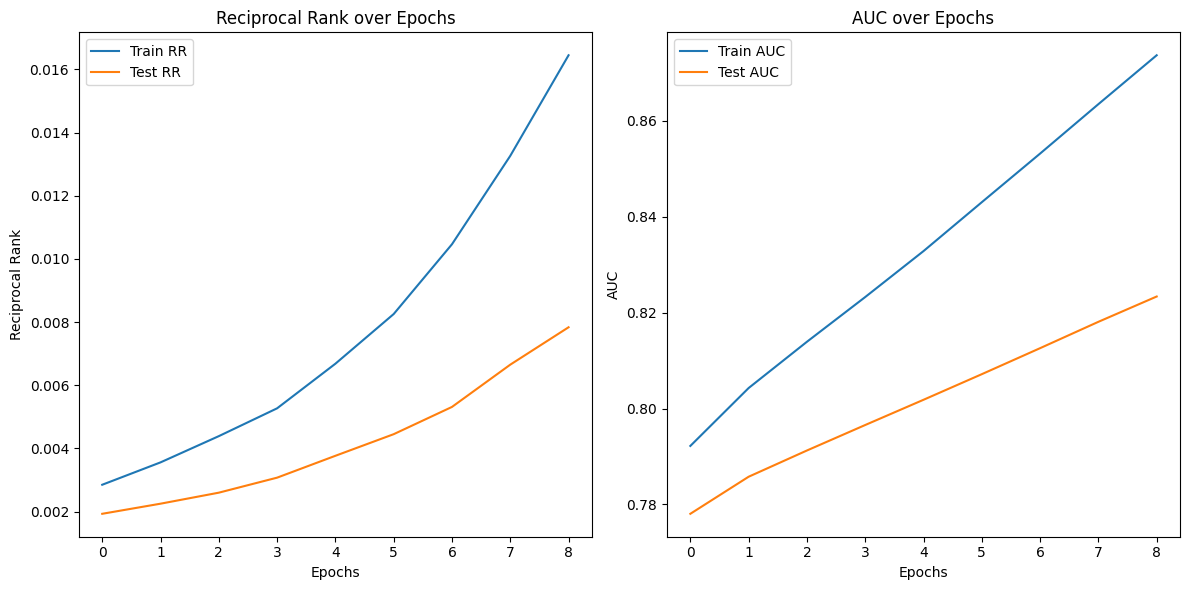

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_rr_list, label='Train RR')
plt.plot(test_rr_list, label='Test RR')
plt.title('Reciprocal Rank over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Reciprocal Rank')
plt.legend()

plt.subplot(122)
plt.plot(train_auc_list, label='Train AUC')
plt.plot(test_auc_list, label='Test AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model = joblib.load('recommendation_hybrid_model.pkl')
test_prediction = model.predict(0, np.arange(10), user_features=user_features, item_features=item_features)
print(test_prediction)

[-1.2113705  -1.0596     -1.146272   -1.1443672  -1.3478926  -1.4719472
 -1.095003    0.44989756 -0.325551   -0.56926006]


In [15]:
# Check if model can predict without error
try:
    test_prediction = model.predict(0, np.arange(10), user_features=user_features, item_features=item_features)
    print("Prediction successful:", test_prediction)
except Exception as e:
    print("Error during prediction:", str(e))


Prediction successful: [-1.2113705  -1.0596     -1.146272   -1.1443672  -1.3478926  -1.4719472
 -1.095003    0.44989756 -0.325551   -0.56926006]


In [16]:
def similar_items(item_id, model, item_features, N=10):
    # Get item representations (biases and features)
    item_bias, item_representations = model.get_item_representations(features=item_features)
    # Compute cosine similarity
    target_item_representation = item_representations[item_id]
    scores = item_representations.dot(target_item_representation)
    top_indices = np.argsort(-scores)[:N]
    return top_indices

# Example of finding similar items
item_id = 13842
similar_ids = similar_items(item_id, model, item_features)
print("Similar Items to Item ID 10:", similar_ids)

Similar Items to Item ID 10: [29028 29014 29020 29043 10160  9098 29008  9052 27508 29016]


In [17]:
def similar_users(user_id, model, user_features, N=10):
    user_bias, user_representations = model.get_user_representations(features=user_features)
    target_user_representation = user_representations[user_id]
    scores = user_representations.dot(target_user_representation)
    top_indices = np.argsort(-scores)[:N]
    return top_indices

# Example of finding similar items
user_id = 39
similar_ids = similar_users(user_id, model, user_features)
print("Similar users:", similar_ids)

Similar users: [30104 45742 46943 96146  5332 46219 30766 27457 99434 12443]


In [18]:
def generate_recommendations(model, user_id, user_features, item_features, dataset, products_df, num_items=10):
    user_x = dataset.mapping()[0][user_id]
    scores = model.predict(user_x, np.arange(dataset.interactions_shape()[1]), user_features=user_features, item_features=item_features)
    top_items_indices = np.argsort(-scores)[:num_items]
    top_items_ids = [dataset.mapping()[2][i] for i in top_items_indices]
    # Get item names or other details from products_df
    top_items_details = products_df[products_df['id'].isin(top_items_ids)][['id', 'name']]
    return top_items_details

# Example of finding similar items
user_id = 39 # You need to replace this with a valid item ID from your dataset
recommendations = generate_recommendations(model, user_id, user_features, item_features, dataset,products_df, num_items=10)
print(recommendations)

          id                                               name
3289    7796        Rebecca Minkoff Women's Joni Harness Jacket
3824   13525  Becca by Rebecca Virtue South of the Border Bu...
10490  16033            Robert Graham Men's Clark Regular Cuffs
15132   3352                       2B Gabrielle Tank Maxi Dress
20880  20460  Men's Turquoise Paisley Jacquard Suit Vest and...
21033  20814            True Religion Men's Billy Boot Cut Jean
22805  15645  Angelina 1/2 Cotton + 1/2 Lace Year-Round Ligh...
26408  27063      Family Guy Stewie Men's Microfleece Sleep Set
27238  14392  La Leche League International Pullover Nursing...
28390   3394                     maxandcleo Women's Layla Dress


Solution for Cold Start Problem

In [40]:
from scipy.sparse import csr_matrix

# Define user features as a dictionary or similar structure
features_dict = {
    'gender_male': 1,
    'age_25': 1,
    'location_Daegu': 1,
    'brand_Perry_Ellis': 1
}

# Assuming the total number of features is known and indexed
num_features = 100  # Adjust this to the actual number of different feature tokens you have
feature_indices = {
    'gender_male': 0,
    'age_25': 1,
    'location_Daegu': 2,
    'brand_Perry_Ellis': 3
}

# Create feature vector
feature_vector = [0] * num_features
for feature, index in feature_indices.items():
    if feature in features_dict:
        feature_vector[index] = features_dict[feature]

# Convert to CSR matrix
user_features_csr = csr_matrix(feature_vector)


In [41]:
# Load the model
model = joblib.load('recommendation_hybrid_model.pkl')

# Predicting with a manually created CSR matrix
num_items = dataset.interactions_shape()[1]  # Number of items
new_user_predictions = model.predict(0, np.arange(num_items), user_features=user_features_csr, item_features=item_features)

# Output the predictions
print("Predictions:", new_user_predictions)

Predictions: [-0.65928894 -0.640985   -0.6363938  ... -0.5210588  -0.53836757
 -0.5682372 ]


In [42]:
import numpy as np
import joblib

# Load the model
model = joblib.load('recommendation_hybrid_model.pkl')

# Predicting with a manually created CSR matrix
num_items = dataset.interactions_shape()[1]  # Number of items
new_user_predictions = model.predict(0, np.arange(num_items), user_features=user_features_csr, item_features=item_features)

# Extract the indices of the top items based on scores
top_items_indices = np.argsort(-new_user_predictions)[:10]

# Get the IDs of the top items from the indices
top_item_ids = products_df.iloc[top_items_indices]['id']

# Fetch details for these top items from your products DataFrame
top_items_details = products_df[products_df['id'].isin(top_item_ids)][['id', 'name']]

# Output the top item details
print("Top Recommended Items:")
print(top_items_details)


Top Recommended Items:
          id                                               name
2311   18788         Mundo Unico Men's Classic Jock Strap Thong
3389   23977                            Men's Cashmere Pea Coat
7696   26507  Majestic International Men's Weather Wise Flan...
11135  26818     Croft & BarrowÂ® Men's Camouflage Lounge Pants
13651  23069    Tommy Bahama Key Grip Cargo Bermuda Golf Shorts
18719  20198          Port Authority J753 Classic Poplin Jacket
20570  23131     Ed Garments Men's Flat Front Chino Short. 2450
20573  23416  Ed Garments Men's Flat Front Utility Cargo Sho...
24315  24158  Charles River Apparel Men's Windproof Hooded R...
28251  22312             Royal Bones Red Plaid Zip Skinny Pants


In [43]:
from scipy.sparse import csr_matrix

# Updated user features for a female user
features_dict = {
    'gender_female': 1,  # Assuming the model was trained with this feature
    'age_25': 1,
    'location_Daegu': 1,
    'brand_Perry_Ellis': 1
}

# Assuming the total number of features is known and indexed, update accordingly
num_features = 100  # This should match your model's feature setup
feature_indices = {
    'gender_female': 1,  # Update the index as per your model's feature indexing
    'age_25': 1,
    'location_Daegu': 2,
    'brand_Perry_Ellis': 3
}

# Create the feature vector based on the defined features
feature_vector = [0] * num_features
for feature, index in feature_indices.items():
    if feature in features_dict:
        feature_vector[index] = features_dict[feature]

# Convert to CSR matrix
user_features_csr = csr_matrix(feature_vector)

# Load the model
model = joblib.load('recommendation-model/recommendation_hybrid_model.pkl')

# Predicting with a manually created CSR matrix
num_items = dataset.interactions_shape()[1]  # Number of items
new_user_predictions = model.predict(0, np.arange(num_items), user_features=user_features_csr, item_features=item_features)

# Output the predictions
print("Predictions:", new_user_predictions)

# Predicting with a manually created CSR matrix
num_items = dataset.interactions_shape()[1]  # Number of items
new_user_predictions = model.predict(0, np.arange(num_items), user_features=user_features_csr, item_features=item_features)

# Extract the indices of the top items based on scores
top_items_indices = np.argsort(-new_user_predictions)[:20]

# Get the IDs of the top items from the indices
top_item_ids = products_df.iloc[top_items_indices]['id']

# Fetch details for these top items from your products DataFrame
top_items_details = products_df[products_df['id'].isin(top_item_ids)][['id', 'name']]

# Output the top item details
print("Top Recommended Items:")
print(top_items_details)


Predictions: [-0.34894386 -0.36325666 -0.3358236  ... -0.20552522 -0.26094827
 -0.27519575]
Top Recommended Items:
         id                                               name
25609  7488  Allegra K Lady V Neck Single Breasted Puff Sle...
25610  7490  Allegra K Lady Single Button Fastening Long Sl...
25622  7543  Allegra K Ladies Single Button Closure Front P...
25624  7571  Allegra K Ladies Single Breasted Button-tab Pu...
25629  7612  Allegra K Lady Shawl Collar Long Sleeve Button...
25633  7625  Allegra K Ladies Long Sleeve Solid Color Hook ...
25646  7675  Allegra K Lady Long Sleeve Front Opening Two P...
25648  7695  Allegra K Front Opening Long Sleeve Womenwear ...
25649  7699  Allegra K Lady Long Sleeve Shawl Collar Button...
25651  7722  Allegra K Ladies Capri Sleeve Front Opening Pa...
25684  7856  Allegra K Women Deep V Neck Long Sleeves Butto...
25686  7861  Allegra K Women Striped Long Sleeve Cropped Au...
25696  7876  Allegra K Ladies Padded Shoulder Long Sleeve F...
257